In [1]:
import pandas as pd
import requests
import zipfile
import io
import os
import csv
import ctypes as ct
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sns

from bgs.load_bgs_amounts import load_bgs_amounts
from bgs.load_gilt_details import load_csv_blocks
from bgs.load_bgs_prices import load_prices
from bgs.gilt_analytics import gilt_yield

def clean_date(bgs_index):
    if re.match(r'^\d{2}\s\w{3}\s+\d{4}$', bgs_index):
        return pd.to_datetime(bgs_index, format="%d %b %Y", errors='coerce').to_period('M').to_timestamp('M')
    else:
        return pd.to_datetime(bgs_index).to_period('M').to_timestamp('M')

def clean_percentage(x):
    if x.strip() in ['Variable','Floating']:
        return x
    try:
        x = float(x)
    except (ValueError, TypeError):
        units, fractions = x.split(' ')
        num, denom = map(float, fractions.split('/'))
        x = float(units) + num / denom
        print(x)
    return x
tables = load_bgs_amounts("downloads/BGSAmounts.csv")

conv = tables['Conventionals']
conv.replace("Redeemed", "", inplace=True)
conv = conv.apply(pd.to_numeric, errors='coerce')
conv.fillna(0, inplace=True)
conv.index = pd.Index([clean_date(x) for x in list(conv.index)]).to_period('M').to_timestamp('M')

old = tables['Calculated indexed nominal Old-style']
old.replace("Redeemed", "", inplace=True)
old = old.apply(pd.to_numeric, errors='coerce')
old.fillna(0, inplace=True)
old.index = pd.Index([clean_date(x) for x in list(old.index)]).to_period('M').to_timestamp('M')

new = tables['Calculated indexed nominal New-style']
new.replace("Redeemed", "", inplace=True)
new = new.apply(pd.to_numeric, errors='coerce')
new.fillna(0, inplace=True)
new.index = pd.Index([clean_date(x) for x in list(new.index)]).to_period('M').to_timestamp('M')

new_no_idx = tables['Index-linked New-style']
new_no_idx.replace("Redeemed", "", inplace=True)
new_no_idx = new_no_idx.apply(pd.to_numeric, errors='coerce')
new_no_idx.fillna(0, inplace=True)
new_no_idx.index = pd.Index([clean_date(x) for x in list(new_no_idx.index)]).to_period('M').to_timestamp('M')

price_df=load_prices("downloads/BGSPrices.csv")
price_df.index = pd.to_datetime(price_df.index, format="%d %b %Y").to_period('M').to_timestamp('M')
for text in ['Amalgamated', 'Redeemed', 'redeemed']:
    price_df = price_df.replace(text, 0)
price_df = price_df.replace('missing', None)
price_df = price_df.ffill(axis=0)
price_df = price_df.fillna(0)
details = load_csv_blocks("downloads/BGSDetails.csv")

conv_details = details['Conventionals']
conv_details['%'] = conv_details['%'].apply(clean_percentage)

new_details = details['Index-Linked New-style']
new_details['%'] = new_details['%'].apply(clean_percentage)

old_details = details['Index-Linked Old-style']
old_details['%'] = old_details['%'].apply(clean_percentage)


/tmp/ipykernel_732/1470390927.py:65: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.replace(text, 0)
/tmp/ipykernel_732/1470390927.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  price_df = price_df.ffill(axis=0)


3.75


In [2]:
last = '2025-04-30'

In [3]:
outstanding = conv.loc[last, conv.loc[last] !=0].reset_index()['index'].to_list()
outstanding[0]

'32010'

In [4]:
last_price = price_df.loc[last, [int(x) for x in outstanding]]
principal = conv.loc[last, outstanding]

In [5]:
principal.index = principal.index.astype(int)
principal.name = 'balance_outstanding'
last_price.name = 'price'

In [6]:
data_set_april = last_price.reset_index().merge(principal.reset_index(), on='index')
data_set_april.rename(columns={'index': 'Sequence'}, inplace=True)

In [7]:
(data_set_april['balance_outstanding']*data_set_april['price']).sum()/data_set_april['balance_outstanding'].sum()

np.float64(84.30712186947953)

In [8]:
(data_set_april['balance_outstanding']*0.16).sum()


np.float64(327709.39135999995)

In [9]:
data_set_april.head()

,Sequence,price,balance_outstanding
0,32010,99.628,44622.873
1,32025,99.264,40343.001
2,32026,99.686,36016.346
3,32027,97.767,41177.698
4,32030,97.476,44673.738


In [10]:
conv_details['Sequence'] = conv_details['Sequence'].astype(int)

In [11]:
len([x for x in conv_details['Sequence'] if x in [int(y) for y in outstanding]])

66

In [12]:
len(outstanding)

66

In [13]:
conv_details.columns

Index(['Sequence', 'Inst Code', 'Sedol', 'ISIN Code', '%', 'Stock', 'Suffix',
       'Special features', 'First year', 'Last year', 'Issue date',
       'First coupon payable on date', 'Earliest redemption date',
       'Latest redemption date', 'A (B, C ...) stock merged on date',
       'Actually redeemed or amalgamated', 'Frequency', 'Payment date 1',
       'Payment date 2', 'Payment date 3', 'Payment date 4', 'First coupon',
       'Last coupon', 'Col for I-L 1', 'Col for I-L 2', 'Col for I-L 3',
       'Col for I-L 4', 'Col for I-L 5', 'Number of calls', 'Call payment 1',
       'due on 1', 'Call payment 2', 'due on 2', 'Call payment 3', 'due on 3',
       'Call payment 4', 'due on 4'],
      dtype='object')

In [14]:
date_variables = ["Latest redemption date","Issue date","First coupon payable on date",]
static_variables = ['%', "Frequency","Sequence",'ISIN Code']+date_variables
data_set_april = data_set_april.merge(conv_details[static_variables].set_index("Sequence"), on='Sequence', how='inner')
for date_var in date_variables:
    data_set_april[date_var] = data_set_april[date_var].apply(clean_date)
data_set_april.head()

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date
0,32010,99.628,44622.873,0.625,2,GB00BK5CVX03,2025-06-30,2019-07-31,2019-12-31
1,32025,99.264,40343.001,2.0,2,GB00BTHH2R79,2025-09-30,2015-03-31,2015-09-30
2,32026,99.686,36016.346,3.5,2,GB00BPCJD880,2025-10-31,2023-01-31,2023-04-30
3,32027,97.767,41177.698,0.125,2,GB00BL68HJ26,2026-01-31,2020-06-30,2021-01-31
4,32030,97.476,44673.738,1.5,2,GB00BYZW3G56,2026-07-31,2016-02-29,2016-07-31


In [15]:
(data_set_april['balance_outstanding']*data_set_april['%']).sum()/data_set_april['balance_outstanding'].sum()

np.float64(2.6749981430864787)

<Axes: ylabel='Frequency'>

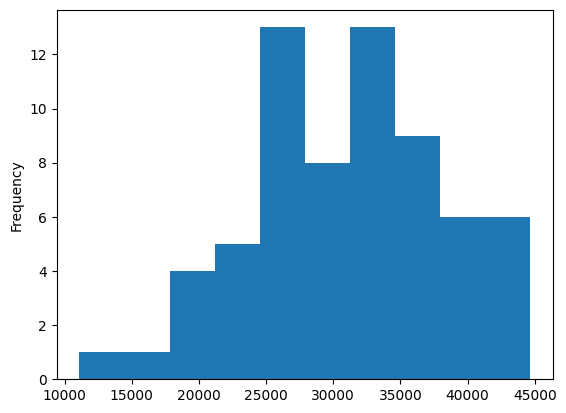

In [16]:
data_set_april['balance_outstanding'].plot(kind='hist')

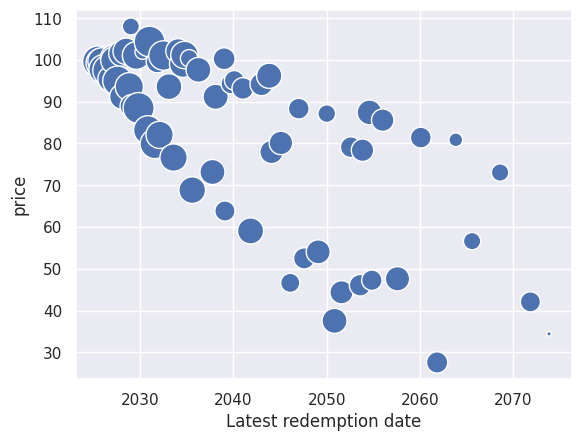

In [17]:
sns.set_theme(style="darkgrid")

# use the scatterplot function to build the bubble map
ax = sns.scatterplot(
    data=data_set_april,
    x="Latest redemption date",
    y="price",
    size="balance_outstanding",
    legend=False,
    sizes=(10, 500)
)

# show the graph
plt.show()

In [18]:
range = ax.get_xaxis().get_data_interval()


In [19]:
(data_set_april['Latest redemption date'].min() - pd.Timestamp("1970-01-01")).days 

20269

In [20]:
X = ((data_set_april['Latest redemption date'] - pd.Timestamp("1970-01-01")).dt.days).to_list()
# X = [np.array(X)[:, np.newaxis]]
X = np.array(X).reshape(-1, 1)
y = data_set_april['price']

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.svm import SVR

pipeline = make_pipeline(
    preprocessing.StandardScaler(),
    SVR(kernel='linear', epsilon=0.01, C=100, gamma = 0.01),
)

In [22]:
pipeline.fit(X, y)

,steps,"[('standardscaler', ...), ('svr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,kernel,'linear'
,degree,3
,gamma,0.01
,coef0,0.0


In [23]:
y_hat = pipeline.predict(X)

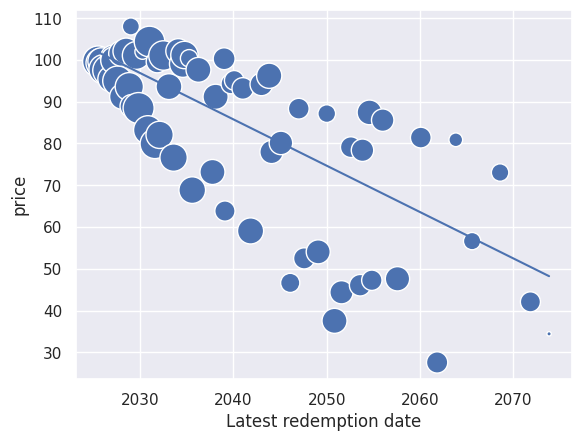

In [24]:
sns.set_theme(style="darkgrid")

# use the scatterplot function to build the bubble map
ax = sns.scatterplot(
    data=data_set_april,
    x="Latest redemption date",
    y="price",
    size="balance_outstanding",
    legend=False,
    sizes=(10, 500)
)

# show the graph
ax.plot(data_set_april['Latest redemption date'], y_hat)
plt.show()

In [25]:
decision_line = pd.DataFrame(
    {
        "Latest redemption date": data_set_april['Latest redemption date'],
        "decision_line_price": y_hat
    })

In [26]:
data_set_april = data_set_april.merge(decision_line, on='Latest redemption date', how='inner')

<Axes: title={'center': 'Difference between decision line and actual price'}, ylabel='Frequency'>

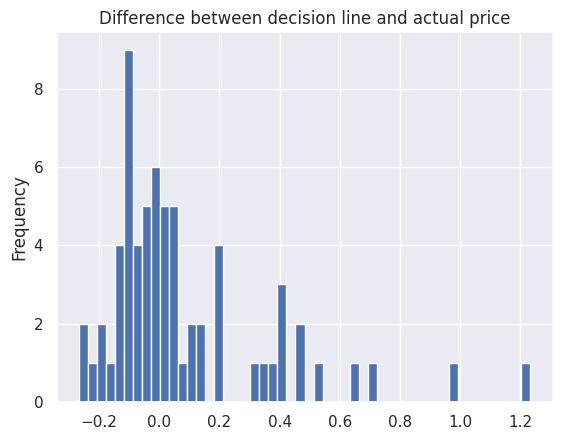

In [27]:
((data_set_april['decision_line_price'] - data_set_april['price'])/data_set_april['price']).plot(kind='hist', bins=50, title='Difference between decision line and actual price')

In [28]:
(y_hat.max()-y_hat.min())/(range[1] -range[0])

np.float64(0.003037146132126733)

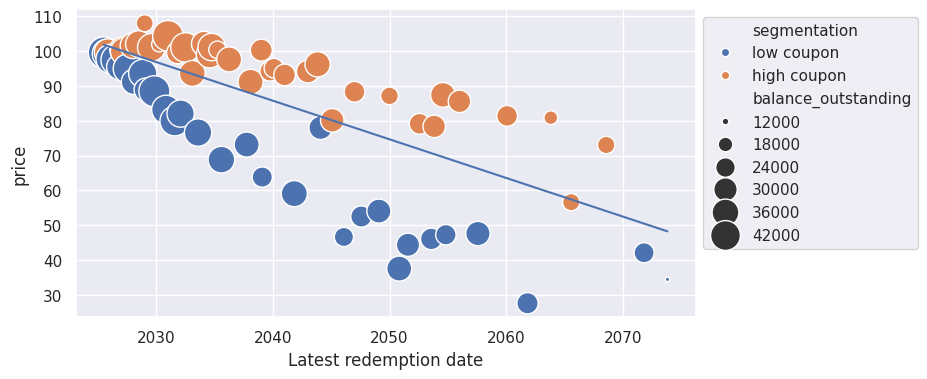

In [29]:
sns.set_theme(style="darkgrid")

f, axs = plt.subplots(1, 1, figsize=(8, 4))

condition = (data_set_april['decision_line_price'] - data_set_april['price']) > 2
data_set_april['segmentation'] = condition.apply(lambda x: 'low coupon' if x else 'high coupon')

# use the scatterplot function to build the bubble map
sns.scatterplot(
    data=data_set_april,
    x="Latest redemption date",
    y="price",
    size="balance_outstanding",
    sizes=(10, 500),
    hue='segmentation',
    legend='brief',
    ax=axs
)

# show the graph
axs.plot(data_set_april['Latest redemption date'], y_hat, )
sns.move_legend(axs, "upper left", bbox_to_anchor=(1, 1))
f.show()

In [30]:
focus = data_set_april.loc[(data_set_april['segmentation'] == 'low coupon')&(data_set_april['price']<100)].copy()

In [31]:
focus['balance_outstanding'].sum()

np.float64(994473.016)

In [32]:
((100 - focus['price'])*focus['balance_outstanding']).sum()/100

np.float64(261108.46368138003)

In [33]:
focus

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date,decision_line_price,segmentation
0,32010,99.628,44622.873,0.625,2,GB00BK5CVX03,2025-06-30,2019-07-31,2019-12-31,101.850769,low coupon
1,32025,99.264,40343.001,2.0,2,GB00BTHH2R79,2025-09-30,2015-03-31,2015-09-30,101.571352,low coupon
3,32027,97.767,41177.698,0.125,2,GB00BL68HJ26,2026-01-31,2020-06-30,2021-01-31,101.197783,low coupon
4,32030,97.476,44673.738,1.5,2,GB00BYZW3G56,2026-07-31,2016-02-29,2016-07-31,100.648060,low coupon
5,32035,95.463,33660.598,0.375,2,GB00BNNGP668,2026-10-31,2021-03-31,2021-10-31,100.368642,low coupon
8,32040,94.976,41947.822,1.25,2,GB00BDRHNP05,2027-07-31,2017-03-31,2017-07-31,99.539501,low coupon
10,32060,91.201,33260.277,0.125,2,GB00BMBL1G81,2028-01-31,2020-06-30,2021-01-31,98.980666,low coupon
13,32075,93.590,38743.345,1.625,2,GB00BFX0ZL78,2028-10-31,2018-03-31,2018-10-31,98.148488,low coupon
15,32110,88.940,29597.495,0.5,2,GB00BLPK7227,2029-01-31,2021-09-30,2022-01-31,97.869071,low coupon
17,32125,88.474,44643.059,0.875,2,GB00BJMHB534,2029-10-31,2019-06-30,2019-10-31,97.039930,low coupon


In [34]:
# 

In [35]:
data_set_april.tail(20)

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date,decision_line_price,segmentation
46,32250,88.33,25714.239,4.25,2,GB00B128DP45,2046-12-31,2006-05-31,2006-12-31,77.997024,high coupon
47,32255,52.49,26325.428,1.5,2,GB00BDCHBW80,2047-07-31,2016-09-30,2017-01-31,77.353149,low coupon
48,32257,54.05,30932.767,1.75,2,GB00BFWFPP71,2049-01-31,2018-09-30,2019-01-31,75.682718,low coupon
49,32260,87.15,21541.402,4.25,2,GB00B39R3707,2049-12-31,2008-09-30,2008-12-31,74.668312,high coupon
50,32262,37.53,32663.871,0.625,2,GB00BMBL1F74,2050-10-31,2020-06-30,2020-10-31,73.745019,low coupon
51,32263,44.37,29538.747,1.25,2,GB00BLH38158,2051-07-31,2021-04-30,2021-07-31,72.915878,low coupon
52,32265,79.12,25703.101,3.75,2,GB00B6RNH572,2052-07-31,2011-09-30,2012-01-31,71.804283,high coupon
53,32266,46.06,26928.000,1.5,2,GB00BM8Z2V59,2053-07-31,2021-10-31,2022-01-31,70.695724,low coupon
54,32267,78.38,28287.997,3.75,2,GB00BPCJD997,2053-10-31,2023-01-31,2023-04-30,70.416307,high coupon
55,32268,87.44,32127.870,4.375,2,GB00BPSNBB36,2054-07-31,2024-01-31,2024-07-31,69.587166,high coupon


In [36]:
data_set_april[data_set_april['ISIN Code'].isin(['GB00BMBL1D50', 'GB00B54QLM75'])]

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date,decision_line_price,segmentation
59,32280,81.41,25722.409,4.0,2,GB00B54QLM75,2060-01-31,2009-10-31,2010-01-31,63.482502,high coupon
60,32282,27.57,26493.249,0.5,2,GB00BMBL1D50,2061-10-31,2020-05-31,2020-10-31,61.541766,low coupon


In [37]:
convexity = price_df.loc["2020-05-31":, [32280, 32282]]

In [38]:
convexity.head()

,32280,32282
2020-05-31,227.03,101.40
2020-06-30,222.04,98.30
2020-07-31,222.12,98.24
2020-08-31,205.83,88.45
2020-09-30,212.95,93.01


In [39]:
"UKT_4%_2060", "UKT_0.5%_2061"

('UKT_4%_2060', 'UKT_0.5%_2061')

In [40]:
convexity.loc["2020-05-31",32280]

np.float64(227.03)

In [41]:
id = 32282
bond = data_set_april[data_set_april['Sequence']==id]
issue_date=bond['Issue date'].dt.strftime("%Y-%m-%d").values[0]
maturity_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
first_cpn_date=bond['First coupon payable on date'].dt.strftime("%Y-%m-%d").values[0]
last_cpn_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
coupon=bond['%'].values[0]/100

today="2020-06-30"
clean_price=convexity.loc[today,id]


gilt_yield(
    today=today,
    issue_date=issue_date,
    maturity_date=maturity_date,
    first_cpn_date=first_cpn_date,
    last_cpn_date=last_cpn_date,
    clean_price=clean_price,
    coupon=coupon
)

0.5460011328275194

In [42]:
today, issue_date, maturity_date, first_cpn_date, last_cpn_date, clean_price, coupon

('2020-06-30',
 '2020-05-31',
 '2061-10-31',
 '2020-10-31',
 '2061-10-31',
 np.float64(98.3),
 0.005)

In [43]:
r = convexity[32280].reset_index().iterrows().__next__()


In [44]:
r[1]['index'].isoformat().split("T")[0]

'2020-05-31'

In [45]:
r[1][32280]

227.03

In [46]:
def yield_series(price_series, issue_date, maturity_date, first_cpn_date, last_cpn_date, coupon):
    # Calculate the yield series based on the provided parameters
    name = price_series.name
    df = price_series.reset_index().rename(columns={name: "price"})
    df['yield'] = df.apply(lambda x: gilt_yield(
        today=x['index'].isoformat().split("T")[0],
        issue_date=issue_date,
        maturity_date=maturity_date,
        first_cpn_date=first_cpn_date,
        last_cpn_date=last_cpn_date,
        clean_price=x["price"],
        coupon=coupon/100
    ), axis=1)
    df.set_index('index', inplace=True)
    return df

In [47]:
id = 32280
bond = data_set_april[data_set_april['Sequence']==id]
issue_date=bond['Issue date'].dt.strftime("%Y-%m-%d").values[0]
maturity_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
first_cpn_date=bond['First coupon payable on date'].dt.strftime("%Y-%m-%d").values[0]
last_cpn_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
coupon=bond['%'].values[0]

ukt_4_2060 = yield_series(convexity[id], issue_date, maturity_date, first_cpn_date, last_cpn_date, coupon)


In [48]:
id = 32282
bond = data_set_april[data_set_april['Sequence']==id]
issue_date=bond['Issue date'].dt.strftime("%Y-%m-%d").values[0]
maturity_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
first_cpn_date=bond['First coupon payable on date'].dt.strftime("%Y-%m-%d").values[0]
last_cpn_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
coupon=bond['%'].values[0]
ukt_0_5_2061 = yield_series(convexity[id], issue_date, maturity_date, first_cpn_date, last_cpn_date, coupon)

In [49]:
ukt_4_2060['norm_price'] = ukt_4_2060['price']/ukt_4_2060['price'].max()
ukt_0_5_2061['norm_price'] = ukt_0_5_2061['price']/ukt_0_5_2061['price'].max()

<Axes: xlabel='yield', ylabel='norm_price'>

<Figure size 1000x500 with 0 Axes>

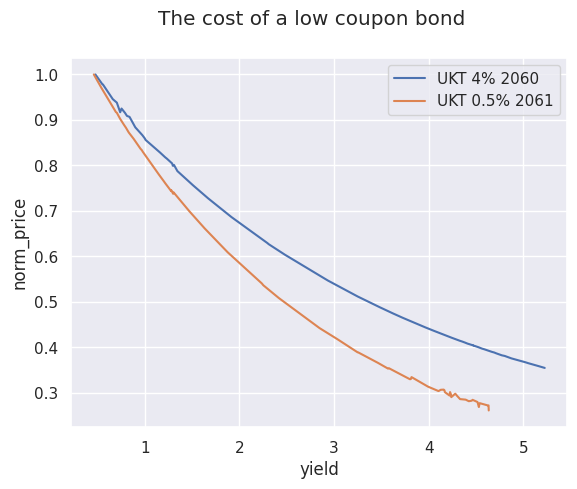

In [50]:
f = plt.figure(figsize=(10, 5), )
fig, ax = plt.subplots(1, 1)
fig.suptitle("The cost of a low coupon bond")
sns.lineplot(data=ukt_4_2060, x='yield',y='norm_price', label='UKT 4% 2060', ax=ax)
sns.lineplot(data=ukt_0_5_2061, x='yield',y='norm_price', label='UKT 0.5% 2061', ax=ax)

In [51]:
ukt_0_5_2061.tail()

,price,yield,norm_price
index,,,
2024-12-31,28.07,4.537259,0.276824
2025-01-31,28.32,4.514869,0.279290
2025-02-28,28.81,4.462736,0.284122
2025-03-31,27.55,4.625891,0.271696
2025-04-30,27.57,4.631459,0.271893


<Axes: title={'center': 'Low Price Bonds no longer reflecting Economics'}, xlabel='index'>

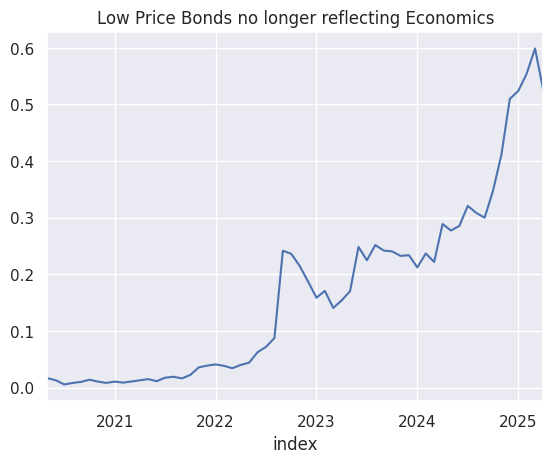

In [52]:
(ukt_4_2060['yield'] - ukt_0_5_2061['yield']).plot(title="Low Price Bonds no longer reflecting Economics")

In [53]:
# 30 years
data_set_april[data_set_april['Sequence'].isin([32260, 32262])]

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date,decision_line_price,segmentation
49,32260,87.15,21541.402,4.25,2,GB00B39R3707,2049-12-31,2008-09-30,2008-12-31,74.668312,high coupon
50,32262,37.53,32663.871,0.625,2,GB00BMBL1F74,2050-10-31,2020-06-30,2020-10-31,73.745019,low coupon


In [54]:
thirty_years = price_df.loc["2020-06-30":, [32260, 32262]]

In [55]:
id = 32260
bond = data_set_april[data_set_april['Sequence']==id]
issue_date=bond['Issue date'].dt.strftime("%Y-%m-%d").values[0]
maturity_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
first_cpn_date=bond['First coupon payable on date'].dt.strftime("%Y-%m-%d").values[0]
last_cpn_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
coupon=bond['%'].values[0]

ukt4_25_2049 = yield_series(thirty_years[id], issue_date, maturity_date, first_cpn_date, last_cpn_date, coupon)

In [56]:
id = 32262
bond = data_set_april[data_set_april['Sequence']==id]
issue_date=bond['Issue date'].dt.strftime("%Y-%m-%d").values[0]
maturity_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
first_cpn_date=bond['First coupon payable on date'].dt.strftime("%Y-%m-%d").values[0]
last_cpn_date=bond['Latest redemption date'].dt.strftime("%Y-%m-%d").values[0]
coupon=bond['%'].values[0]

ukt0_625_2050 = yield_series(thirty_years[id], issue_date, maturity_date, first_cpn_date, last_cpn_date, coupon)

In [57]:
ukt4_25_2049['norm_price'] = ukt4_25_2049['price']/ukt4_25_2049['price'].max()
ukt0_625_2050['norm_price'] = ukt0_625_2050['price']/ukt0_625_2050['price'].max()

<Axes: xlabel='yield', ylabel='norm_price'>

<Figure size 1000x500 with 0 Axes>

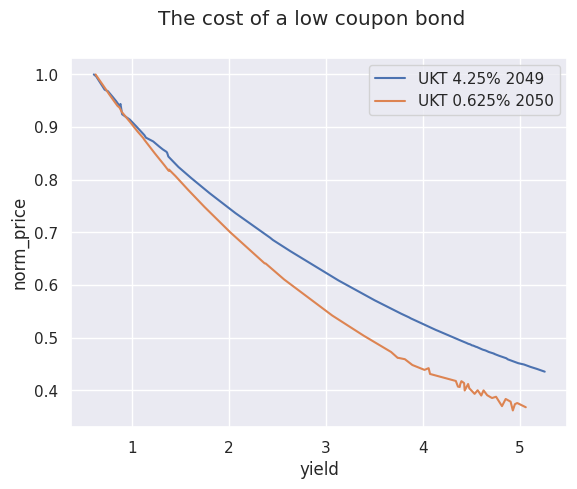

In [58]:
f = plt.figure(figsize=(10, 5), )
fig, ax = plt.subplots(1, 1)
fig.suptitle("The cost of a low coupon bond")
sns.lineplot(data=ukt4_25_2049, x='yield',y='norm_price', label='UKT 4.25% 2049', ax=ax)
sns.lineplot(data=ukt0_625_2050, x='yield',y='norm_price', label='UKT 0.625% 2050', ax=ax)

<Axes: title={'center': 'Low Price Bonds no longer reflecting Economics'}, xlabel='index'>

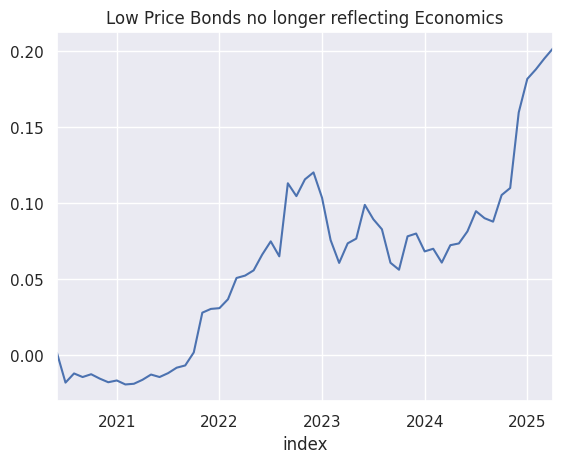

In [59]:
(ukt4_25_2049['yield'] - ukt0_625_2050['yield']).plot(title="Low Price Bonds no longer reflecting Economics")

<Axes: xlabel='index', ylabel='price'>

<Figure size 1000x500 with 0 Axes>

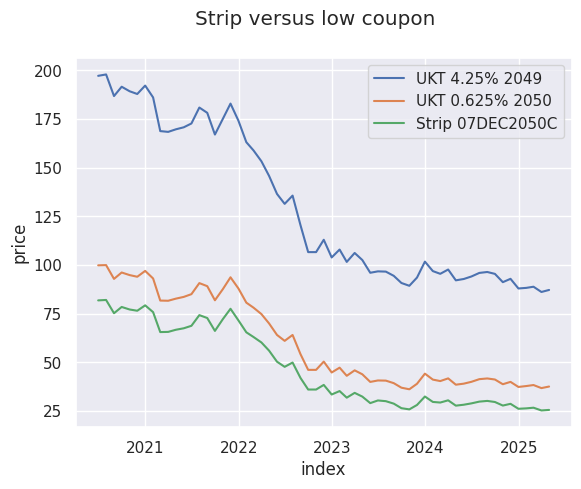

In [60]:
# 30 year UK Treasury Strip 07DEC2050C = 76800	UKT07DEC2050C	GB00B0BDTH75
strip = price_df.loc["2020-06-30":, 76800].reset_index().rename(columns={76800: "price"}).set_index('index')
f = plt.figure(figsize=(10, 5), )
fig, ax = plt.subplots(1, 1)
fig.suptitle("Strip versus low coupon")
sns.lineplot(data=ukt4_25_2049, x=ukt4_25_2049.index,y='price', label='UKT 4.25% 2049', ax=ax)
sns.lineplot(data=ukt0_625_2050, x=ukt0_625_2050.index,y='price', label='UKT 0.625% 2050', ax=ax)
sns.lineplot(data=strip, x=strip.index,y=strip['price'], label='Strip 07DEC2050C', ax=ax)


<Axes: >

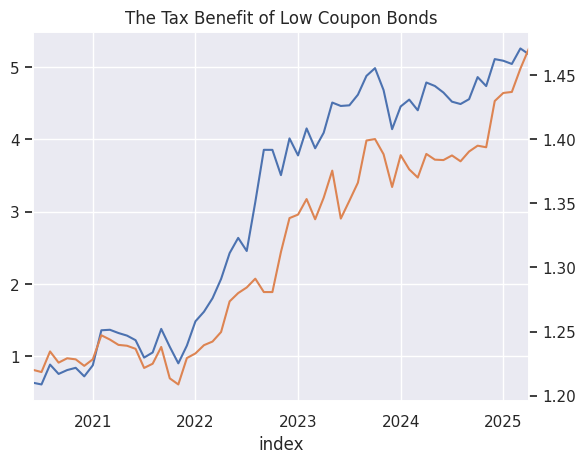

In [61]:

ax = ukt4_25_2049['yield'].plot(title="The Tax Benefit of Low Coupon Bonds")
(ukt0_625_2050['price'] / strip['price']).plot(secondary_y=True)

<Axes: >

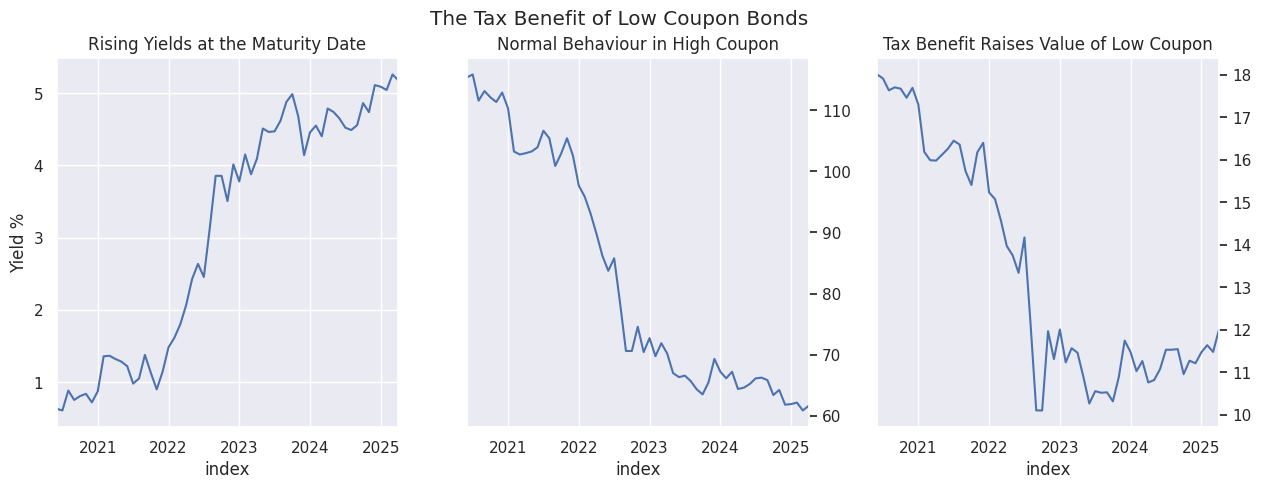

In [62]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.suptitle("The Tax Benefit of Low Coupon Bonds")
ax1.set_title("Rising Yields at the Maturity Date")
ax1.set_ylabel("Yield %")
ax2.set_title("Normal Behaviour in High Coupon")
ax3.set_title("Tax Benefit Raises Value of Low Coupon")
ax3.set_ylabel("Price Diff to Zero Coupon")
ax1 = ukt4_25_2049['yield'].plot(ax=ax1)
(ukt4_25_2049['price'] - strip['price']).plot(ax=ax2, secondary_y=True)
(ukt0_625_2050['price'] - strip['price']).plot(ax=ax3, secondary_y=True)

In [63]:
boe_curves = "downloads/GLC Nominal month end data_2025 to present.xlsx"
df_curves = pd.ExcelFile(boe_curves)
df_curves.sheet_names

['info',
 '1. fwds, short end',
 '2. fwd curve',
 '3. spot, short end',
 '4. spot curve']

In [64]:
df_curve = pd.read_excel(boe_curves, sheet_name='4. spot curve', skiprows=3)

In [65]:
df_curve.head()

,years:,0.5,1,1.5,2,2.5,3,3.5,4,4.5,...,35.5,36,36.5,37,37.5,38,38.5,39,39.5,40
0,2025-01-31,4.217305,4.069581,4.017002,4.011696,4.017633,4.029354,4.046421,4.068572,4.095365,...,5.020454,5.005067,4.988867,4.971847,4.953998,4.935314,4.915788,4.895416,4.874193,4.852119
1,2025-02-28,4.018926,3.961767,3.943119,3.949998,3.959180,3.971373,3.988163,4.009991,4.036640,...,5.009996,4.994743,4.978533,4.961353,4.943194,4.924046,4.903901,4.882755,4.860603,4.837444
2,2025-03-31,4.136179,3.933916,3.957236,3.988113,4.009894,4.031014,4.055935,4.086082,4.121455,...,5.214900,5.197868,5.179834,5.160787,5.140720,5.119626,5.097501,5.074340,5.050143,5.024910
3,2025-04-30,3.813820,3.545525,3.569776,3.601014,3.623882,3.648773,3.680464,3.720028,3.766843,...,5.187582,5.168507,5.148273,5.126876,5.104312,5.080578,5.055676,5.029606,5.002372,4.973980
4,2025-05-30,3.832059,3.735056,3.808936,3.854062,3.881891,3.908245,3.939317,3.976836,4.020624,...,5.380393,5.364010,5.346567,5.328062,5.308492,5.287857,5.266156,5.243394,5.219575,5.194705


In [66]:
df_curve = df_curve.set_index('years:')
spot_curve = df_curve.loc['2025-04-30'].to_dict()

In [67]:
focus.head()

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date,decision_line_price,segmentation
0,32010,99.628,44622.873,0.625,2,GB00BK5CVX03,2025-06-30,2019-07-31,2019-12-31,101.850769,low coupon
1,32025,99.264,40343.001,2.0,2,GB00BTHH2R79,2025-09-30,2015-03-31,2015-09-30,101.571352,low coupon
3,32027,97.767,41177.698,0.125,2,GB00BL68HJ26,2026-01-31,2020-06-30,2021-01-31,101.197783,low coupon
4,32030,97.476,44673.738,1.5,2,GB00BYZW3G56,2026-07-31,2016-02-29,2016-07-31,100.648060,low coupon
5,32035,95.463,33660.598,0.375,2,GB00BNNGP668,2026-10-31,2021-03-31,2021-10-31,100.368642,low coupon


In [68]:
flat_long = spot_curve.get(40)
focus['new coupon'] = ((focus['Latest redemption date'].dt.year-2025) + (focus['Latest redemption date'].dt.month)//6*0.5).apply(
    lambda x: spot_curve.get(x, flat_long))


In [69]:
focus['refinanced'] = (1 - focus['price']/100)*focus['balance_outstanding']

In [70]:
(focus['refinanced']*focus['new coupon']/100).sum()

np.float64(12842.841835408111)

In [71]:
(focus['balance_outstanding']*focus['%']/100).sum()

10827.793457499998

### Bank of England Portfolio

In [72]:
df_buy = pd.read_excel("downloads/gilt-purchase-operational-results.XLSX", sheet_name="APF Gilts", header=1)
df_sell = pd.read_excel("downloads/gilt-sales-time-series.XLSX", sheet_name="APF gilt sales", header=1)

df_boe = df_buy[['Operation date','Total allocation (proceeds £mn)', 'Total allocation (nominal £mn)']].copy()
df_boe['Operation date'] = pd.to_datetime(df_boe['Operation date'], format='%d-%m-%Y')
df_boe.set_index('Operation date', inplace=True)

df_boe_exit = df_sell[['Operation date','Total allocation (proceeds £mn)', 'Total allocation (nominal £mn)']].copy()
df_boe_exit['Operation date'] = pd.to_datetime(df_boe_exit['Operation date'], format='%d-%m-%Y')
df_boe_exit.set_index('Operation date', inplace=True)

In [74]:
isin_bond_details = conv_details[['ISIN Code', 'Latest redemption date','%','Sequence']].copy()

gilt_level_buys = df_buy[[
    'ISIN',
    'Operation date',
    'Total allocation (proceeds £mn)',
    'Total allocation (nominal £mn)'
    ]].copy()
gilt_level_buys.set_index('Operation date', inplace=True)
gilt_level_buys.index = pd.to_datetime(gilt_level_buys.index, format='%d-%m-%Y').to_period('M').to_timestamp('M')
gilt_level_buys.reset_index(inplace=True)

gilt_buys_ts = gilt_level_buys.pivot_table(
    index='Operation date', 
    columns='ISIN', 
    values='Total allocation (nominal £mn)', aggfunc='sum')

gilt_buys_ts = gilt_buys_ts.fillna(0).cumsum()

gilt_buys_total = gilt_level_buys.reset_index().groupby([ 'ISIN']).agg(
    Total_Allocation_Proceeds=('Total allocation (proceeds £mn)', 'sum'),
    Total_Allocation_Nominal=('Total allocation (nominal £mn)', 'sum'),
    Last_Purchase_Month=('Operation date', 'max')
)
gilt_buys_total.reset_index(inplace=True)

gilt_buys_total['maturity_date'] = gilt_buys_total['ISIN'].map(
    lambda x: isin_bond_details[
        isin_bond_details['ISIN Code']==x
        ]['Latest redemption date'].values[0]
    )
gilt_buys_total['bgs_id'] = gilt_buys_total['ISIN'].map(
    lambda x: isin_bond_details[
        isin_bond_details['ISIN Code']==x
        ]['Sequence'].values[0]
)

gilt_buys_total['maturity_date'] = pd.to_datetime(
    gilt_buys_total['maturity_date'], format="%d %b %Y"
)

In [75]:
gilt_level_sales = df_sell[[
    'ISIN',
    'Operation date',
    'Total allocation (proceeds £mn)',
    'Total allocation (nominal £mn)'
    ]].copy()
gilt_level_sales.set_index('Operation date', inplace=True)
gilt_level_sales.index = pd.to_datetime(gilt_level_sales.index, format='%d-%m-%Y').to_period('M').to_timestamp('M')
gilt_level_sales.reset_index(inplace=True)
gilt_level_sales.head()

,Operation date,ISIN,Total allocation (proceeds £mn),Total allocation (nominal £mn)
0,2022-11-30,GB00BL68HJ26,491.108666,545.0
1,2022-11-30,GB00BYZW3G56,0.000000,0.0
2,2022-11-30,GB00BNNGP668,170.287385,192.8
3,2022-11-30,GB00BDRHNP05,45.194932,50.0
4,2022-11-30,GB00B16NNR78,0.000000,0.0


In [76]:
isin_bond_details = conv_details[['ISIN Code', 'Latest redemption date','%','Sequence']].copy()



In [77]:
sales_by_isin=gilt_level_sales.groupby('ISIN')[['Total allocation (nominal £mn)', 'Total allocation (proceeds £mn)']].sum().reset_index()
sales_by_isin['maturity_date'] = sales_by_isin['ISIN'].map(
    lambda x: isin_bond_details[
        isin_bond_details['ISIN Code']==x
        ]['Latest redemption date'].values[0]
    )
sales_by_isin['maturity_date'] = pd.to_datetime(
    sales_by_isin['maturity_date'], format="%d %b %Y"
)

In [78]:
matured_sales = sales_by_isin['maturity_date'] > pd.Timestamp('2025-04-30')
matured = gilt_buys_total['maturity_date'] > pd.Timestamp('2025-04-30')

In [80]:
data_set_april

,Sequence,price,balance_outstanding,%,Frequency,ISIN Code,Latest redemption date,Issue date,First coupon payable on date,decision_line_price,segmentation
0,32010,99.628,44622.873,0.625,2,GB00BK5CVX03,2025-06-30,2019-07-31,2019-12-31,101.850769,low coupon
1,32025,99.264,40343.001,2.0,2,GB00BTHH2R79,2025-09-30,2015-03-31,2015-09-30,101.571352,low coupon
2,32026,99.686,36016.346,3.5,2,GB00BPCJD880,2025-10-31,2023-01-31,2023-04-30,101.477200,high coupon
3,32027,97.767,41177.698,0.125,2,GB00BL68HJ26,2026-01-31,2020-06-30,2021-01-31,101.197783,low coupon
4,32030,97.476,44673.738,1.5,2,GB00BYZW3G56,2026-07-31,2016-02-29,2016-07-31,100.648060,low coupon
...,...,...,...,...,...,...,...,...,...,...,...
61,32283,80.880,17119.248,4.0,2,GB00BMF9LF76,2063-10-31,2023-05-31,2023-10-31,59.324649,high coupon
62,32285,56.620,21057.884,2.5,2,GB00BYYMZX75,2065-07-31,2015-10-31,2016-01-31,57.383913,high coupon
63,32290,73.040,21230.448,3.5,2,GB00BBJNQY21,2068-07-31,2013-06-30,2014-01-31,54.055201,high coupon
64,32295,42.080,24725.323,1.625,2,GB00BFMCN652,2071-10-31,2018-05-31,2018-10-31,50.450108,low coupon


In [83]:
boe_portfolio = gilt_buys_total[matured].set_index('ISIN').merge(
    sales_by_isin[matured_sales][[
        'ISIN',
        'Total allocation (nominal £mn)',
        'Total allocation (proceeds £mn)'
        ]].set_index('ISIN'),
        how='left',
        left_index=True,
        right_index=True,
        suffixes=('_buy', '_sell')
        ).copy().fillna(0).reset_index()

boe_portfolio['mkt_price'] = boe_portfolio['bgs_id'].map(
    lambda x: data_set_april.loc[data_set_april['Sequence']==x]['price'].values[0])

In [84]:
boe_portfolio.head()

,ISIN,Total_Allocation_Proceeds,Total_Allocation_Nominal,Last_Purchase_Month,maturity_date,bgs_id,Total allocation (nominal £mn),Total allocation (proceeds £mn),mkt_price
0,GB0002404191,11893.528404,8906.5,2016-10-31,2028-12-07,32100,676.0,753.199412,108.018
1,GB0004893086,24839.110612,21081.2,2020-10-31,2032-06-07,32200,2722.5,2870.723138,101.061
2,GB0032452392,19803.081357,14928.9,2021-12-31,2036-03-07,32210,5491.3,5597.317757,97.630
3,GB00B00NY175,14736.342683,11492.7,2021-12-31,2038-12-07,32220,1142.1,1209.164545,100.290
4,GB00B06YGN05,13593.064359,10407.4,2021-12-31,2055-12-07,32270,745.0,668.174028,85.580


In [85]:
boe_low_coupon = [boe_isin for boe_isin in boe_portfolio['ISIN'].to_list() if boe_isin in focus['ISIN Code'].to_list()]
boe_high_coupon = [boe_isin for boe_isin in boe_portfolio['ISIN'].to_list() if boe_isin not in focus['ISIN Code'].to_list()]

In [86]:
len(boe_low_coupon), len(boe_high_coupon)

(28, 18)

In [87]:
boe_portfolio['current position'] = boe_portfolio['Total_Allocation_Nominal'] - boe_portfolio['Total allocation (nominal £mn)']

In [88]:
boe_portfolio[boe_portfolio['ISIN'].isin(boe_low_coupon)]['current position'].sum()

np.float64(324838.50000000006)

In [89]:
boe_portfolio[boe_portfolio['ISIN'].isin(boe_high_coupon)]['current position'].sum()

np.float64(200181.69999999998)

In [95]:
boe_portfolio['mtm'] = (boe_portfolio['mkt_price']-100) * boe_portfolio['current position']/100

In [96]:
boe_portfolio[boe_portfolio['ISIN'].isin(boe_low_coupon)]['mtm'].sum()

np.float64(-60451.76924)

In [97]:
boe_portfolio[boe_portfolio['ISIN'].isin(boe_high_coupon)]['mtm'].sum()

np.float64(-12639.594027999996)

In [101]:
# To bring the portfolio to zero and swap everything up will cost
boe_portfolio[boe_portfolio['ISIN'].isin(boe_low_coupon)]['mtm'].sum() + boe_portfolio[boe_portfolio['ISIN'].isin(boe_high_coupon)]['mtm'].sum()

np.float64(-73091.363268)

In [102]:
# The old cost of interest was
(focus['balance_outstanding']*focus['%']/100).sum()

10827.793457499998

In [103]:
# The new cost of interest is
(focus['refinanced']*focus['new coupon']/100).sum()

np.float64(12842.841835408111)

In [104]:
# But the government has reduced the national debt by
((100 - focus['price'])*focus['balance_outstanding']).sum()/100

np.float64(261108.46368138003)

In [106]:
# netting this together with the injection into the BoE portfolio the net reduction in national debt is
reduction = ((100 - focus['price'])*focus['balance_outstanding']).sum()/100 + boe_portfolio[boe_portfolio['ISIN'].isin(boe_low_coupon)]['mtm'].sum() + boe_portfolio[boe_portfolio['ISIN'].isin(boe_high_coupon)]['mtm'].sum()
reduction

np.float64(188017.10041338005)

In [ ]:
# reducing the national debt to gdp by percentage points
f"{reduction / (738159 *4):.2%}"

'6.37%'